<a href="https://colab.research.google.com/github/haizznaam/Risk-Analysis-NEU/blob/main/LendingClub_WoE_PD_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
# Set up Colab Env
import os
os.chdir('/content/drive/MyDrive/Risk Analysis - Spring 2024_NEU')
print("We are currently in the folder of ", os.getcwd())

We are currently in the folder of  /content/drive/MyDrive/Risk Analysis - Spring 2024_NEU


# Context & Objective:

The dataset being used here has 7 years' historical loan data taken from [LendingClub](https://www.lendingclub.com/). By looking at the loan status, we can check if the loan was sanctioned to the customers or not. If the loan status is "charged off" or "default" or the issuance of loan got delayed by 31-120 days, it is a bad loan. We will analyze the characteristics of the customers whose loans belong to **"bad loan"** category and will build a **Probability of Default (PD) Model**, so that is can be used in future to predict the customer will default or not.

We have used some useful concepts:
- Binning,
- Weight of Evidence (WoE),
- Information Value (IV)

**Acknowledgements:**
- Some insightful kernels which discussed the above three topics earlier for other applications are: [Pranav Pandya's work](https://www.kaggle.com/code/pranav84/talkingdata-with-breaking-bad-feature-engg/report), [Bryan Arnold's work](https://www.kaggle.com/code/puremath86/iv-woe-starter-for-python/notebook)
- [This youtube webinar](https://www.youtube.com/watch?v=fiQhxn9RjEQ&t=2873s) on credit risk analysis is also informative

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook')
sns.set_style("whitegrid", {'axes.grid' : False})
plt.tight_layout()

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

<Figure size 640x480 with 0 Axes>

In [25]:
data = pd.read_csv("LendingClub Dataset/loan_data_2007_2014.csv", low_memory=False)
data.drop(columns= ["Unnamed: 0"], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           466285 non-null  int64  
 1   member_id                    466285 non-null  int64  
 2   loan_amnt                    466285 non-null  int64  
 3   funded_amnt                  466285 non-null  int64  
 4   funded_amnt_inv              466285 non-null  float64
 5   term                         466285 non-null  object 
 6   int_rate                     466285 non-null  float64
 7   installment                  466285 non-null  float64
 8   grade                        466285 non-null  object 
 9   sub_grade                    466285 non-null  object 
 10  emp_title                    438697 non-null  object 
 11  emp_length                   445277 non-null  object 
 12  home_ownership               466285 non-null  object 
 13 

Check the "instance attribute summary" section in this [webpage](https://www.rubydoc.info/gems/lending_club/0.0.2/LendingClub/Loan)

# Assigning the Target Column to Identify Bad Loans

In [26]:
# create a new column based on the loan_status column that will be our target variable
data['bad_loan'] = np.where(data.loc[:, 'loan_status'].isin(['Charged Off', 'Default', 'Late (31-120 days)',
                                        'Does not meet the credit policy. Status:Charged Off']), 0, 1)
# Drop the original 'loan_status' column
data.drop(columns = ['loan_status'], inplace = True)

In [27]:
data['bad_loan']

0         1
1         0
2         1
3         1
4         1
         ..
466280    1
466281    0
466282    1
466283    1
466284    1
Name: bad_loan, Length: 466285, dtype: int64

In [28]:
X = data.drop('bad_loan', axis = 1)
y = data['bad_loan']

In [29]:
# display some
data.head(10)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,bad_loan
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
5,1075269,1311441,5000,5000,5000.0,36 months,7.90,156.46,A,A4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
6,1069639,1304742,7000,7000,7000.0,60 months,15.96,170.08,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
7,1072053,1288686,3000,3000,3000.0,36 months,18.64,109.43,E,E1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
8,1071795,1306957,5600,5600,5600.0,60 months,21.28,152.39,F,F2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
9,1071570,1306721,5375,5375,5350.0,60 months,12.69,121.45,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [30]:
#cols that contain missing values
missing_values = data.isnull().mean()
missing_values[missing_values>0].sort_values(ascending=False)

dti_joint                      1.000000
annual_inc_joint               1.000000
total_cu_tl                    1.000000
inq_fi                         1.000000
all_util                       1.000000
max_bal_bc                     1.000000
open_rv_24m                    1.000000
open_rv_12m                    1.000000
il_util                        1.000000
total_bal_il                   1.000000
mths_since_rcnt_il             1.000000
open_il_24m                    1.000000
open_il_12m                    1.000000
open_il_6m                     1.000000
open_acc_6m                    1.000000
verification_status_joint      1.000000
inq_last_12m                   1.000000
mths_since_last_record         0.865666
mths_since_last_major_derog    0.787739
desc                           0.729820
mths_since_last_delinq         0.536906
next_pymnt_d                   0.487286
total_rev_hi_lim               0.150715
tot_coll_amt                   0.150715
tot_cur_bal                    0.150715


# Data Preprocessing:

* We need to drop the columns having > 70% missing values.

* The follwing features are identifiers and can not be used in building model. id, member id, url, title, desc, zipcode and emp_title

* The sub_grade column wll also be droped as it contains the same information as the grade columns.

* Features that contain information about the future will not be included in building the model since those events are yet to occur. The features include next_pymnt_d, recoveries, collection_recovery_fee, total_rec_prncp and total_rec_late_fee

In [31]:
#dropping irrelevant cols & cols with missing values

columns_to_drop = ['id', 'member_id', 'sub_grade', 'emp_title', 'url', 'desc', 'title', 'zip_code', 'next_pymnt_d',
                  'recoveries', 'collection_recovery_fee', 'total_rec_prncp', 'total_rec_late_fee', 'desc', 'mths_since_last_record',
                  'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'open_acc_6m', 'open_il_6m',
                  'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m',
                  'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m','policy_code',]
data.drop(columns=columns_to_drop, inplace=True, axis=1)

data.dropna(inplace=True)

In [32]:
data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,bad_loan
42537,12000,12000,12000.0,36 months,6.62,368.45,A,10+ years,MORTGAGE,105000.0,...,Jan-16,368.45,Jan-16,0.0,INDIVIDUAL,0.0,0.0,267646.0,61100.0,1
42538,12000,12000,12000.0,36 months,13.53,407.40,B,10+ years,RENT,40000.0,...,Sep-15,119.17,Jan-16,0.0,INDIVIDUAL,0.0,15386.0,13605.0,8100.0,1
42539,15000,15000,15000.0,36 months,8.90,476.30,A,2 years,MORTGAGE,63000.0,...,Jan-16,476.30,Jan-16,0.0,INDIVIDUAL,0.0,1514.0,272492.0,15400.0,1
42541,14000,14000,14000.0,36 months,12.85,470.71,B,4 years,RENT,88000.0,...,Jan-16,470.71,Jan-16,0.0,INDIVIDUAL,0.0,0.0,17672.0,4500.0,1
42543,10000,10000,10000.0,36 months,9.67,321.13,B,7 years,MORTGAGE,102000.0,...,Jan-16,321.13,Jan-16,0.0,INDIVIDUAL,0.0,0.0,39143.0,22300.0,1


In [33]:
data.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'pymnt_plan', 'purpose', 'addr_state',
       'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
       'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'application_type', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'bad_loan'],
      dtype='object')

# Data Type Transformation

In [34]:
#check datatypes of data again

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 181686 entries, 42537 to 466284
Data columns (total 41 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   181686 non-null  int64  
 1   funded_amnt                 181686 non-null  int64  
 2   funded_amnt_inv             181686 non-null  float64
 3   term                        181686 non-null  object 
 4   int_rate                    181686 non-null  float64
 5   installment                 181686 non-null  float64
 6   grade                       181686 non-null  object 
 7   emp_length                  181686 non-null  object 
 8   home_ownership              181686 non-null  object 
 9   annual_inc                  181686 non-null  float64
 10  verification_status         181686 non-null  object 
 11  issue_d                     181686 non-null  object 
 12  pymnt_plan                  181686 non-null  object 
 13  purpose        

The following variables are not possessing appropriate data types and should be modified. Also the NaN values should be replaced with zeroes wherever applicable.

- emp_length,
- term,
- issue_d,
- last_pymnt_d,
- last_credit_pull_d
- earliest_cr_line

We will define functions to transform their data types.

In [35]:
data['emp_length'].value_counts()

emp_length
10+ years    69102
2 years      15615
3 years      14172
< 1 year     12812
5 years      11434
1 year       10905
7 years      10601
4 years      10380
6 years      10121
8 years       9191
9 years       7353
Name: count, dtype: int64

In [37]:
# converting emp_length to numeric and assign NaN to zero

def emp_length_convert(df, column):
    # df[column] = df[column].str.replace('\+ years', '')
    df[column] = df[column].str.replace('+', '')
    df[column] = df[column].str.replace('< 1 year', str(0))
    df[column] = df[column].str.replace(' years', '')
    df[column] = df[column].str.replace(' year', '')
    df[column] = pd.to_numeric(df[column])
    df[column].fillna(value = 0, inplace = True)


emp_length_convert(data, 'emp_length')

data['emp_length'].unique()

array([10,  2,  4,  7,  6,  5,  8,  3,  1,  0,  9])

In [38]:
data['emp_length'].dtype

dtype('int64')

**Term**

In [39]:
data['term'].value_counts()

term
 36 months    129478
 60 months     52208
Name: count, dtype: int64

In [40]:
# converting term to numeric

def term_numeric(df, column):
    df[column] = pd.to_numeric(df[column].str.replace(' months', ''))

term_numeric(data, 'term')

In [41]:
data['term'].dtype

dtype('int64')

In [42]:
# preprocessing date cols

def date_columns(df, column):
    # store current month
    today_date = pd.to_datetime('2020-08-01')
    # convert to datetime format
    df[column] = pd.to_datetime(df[column], format = "%b-%y")
    # calculate the difference in months and add to a new column
    df['mths_since_' + column] = round(pd.to_numeric((today_date - df[column]) / np.timedelta64(1, 'M')))
    # make any resulting -ve values to be equal to the max date
    df['mths_since_' + column] = df['mths_since_' + column].apply(lambda x: df['mths_since_' + column].max() if x < 0 else x)
    # drop the original date column
    df.drop(columns = [column], inplace = True)


date_columns(data, 'issue_d')
date_columns(data, 'last_pymnt_d')
date_columns(data, 'last_credit_pull_d')
date_columns(data, 'earliest_cr_line')

In [43]:
# checking for missing values again

missing_values = data.isnull().sum()
missing_values[missing_values>0]/len(data)

Series([], dtype: float64)

# Checking Correlation among Features

In [50]:
numeric_df = data.select_dtypes(include=[np.int64, np.float64])

<Axes: >

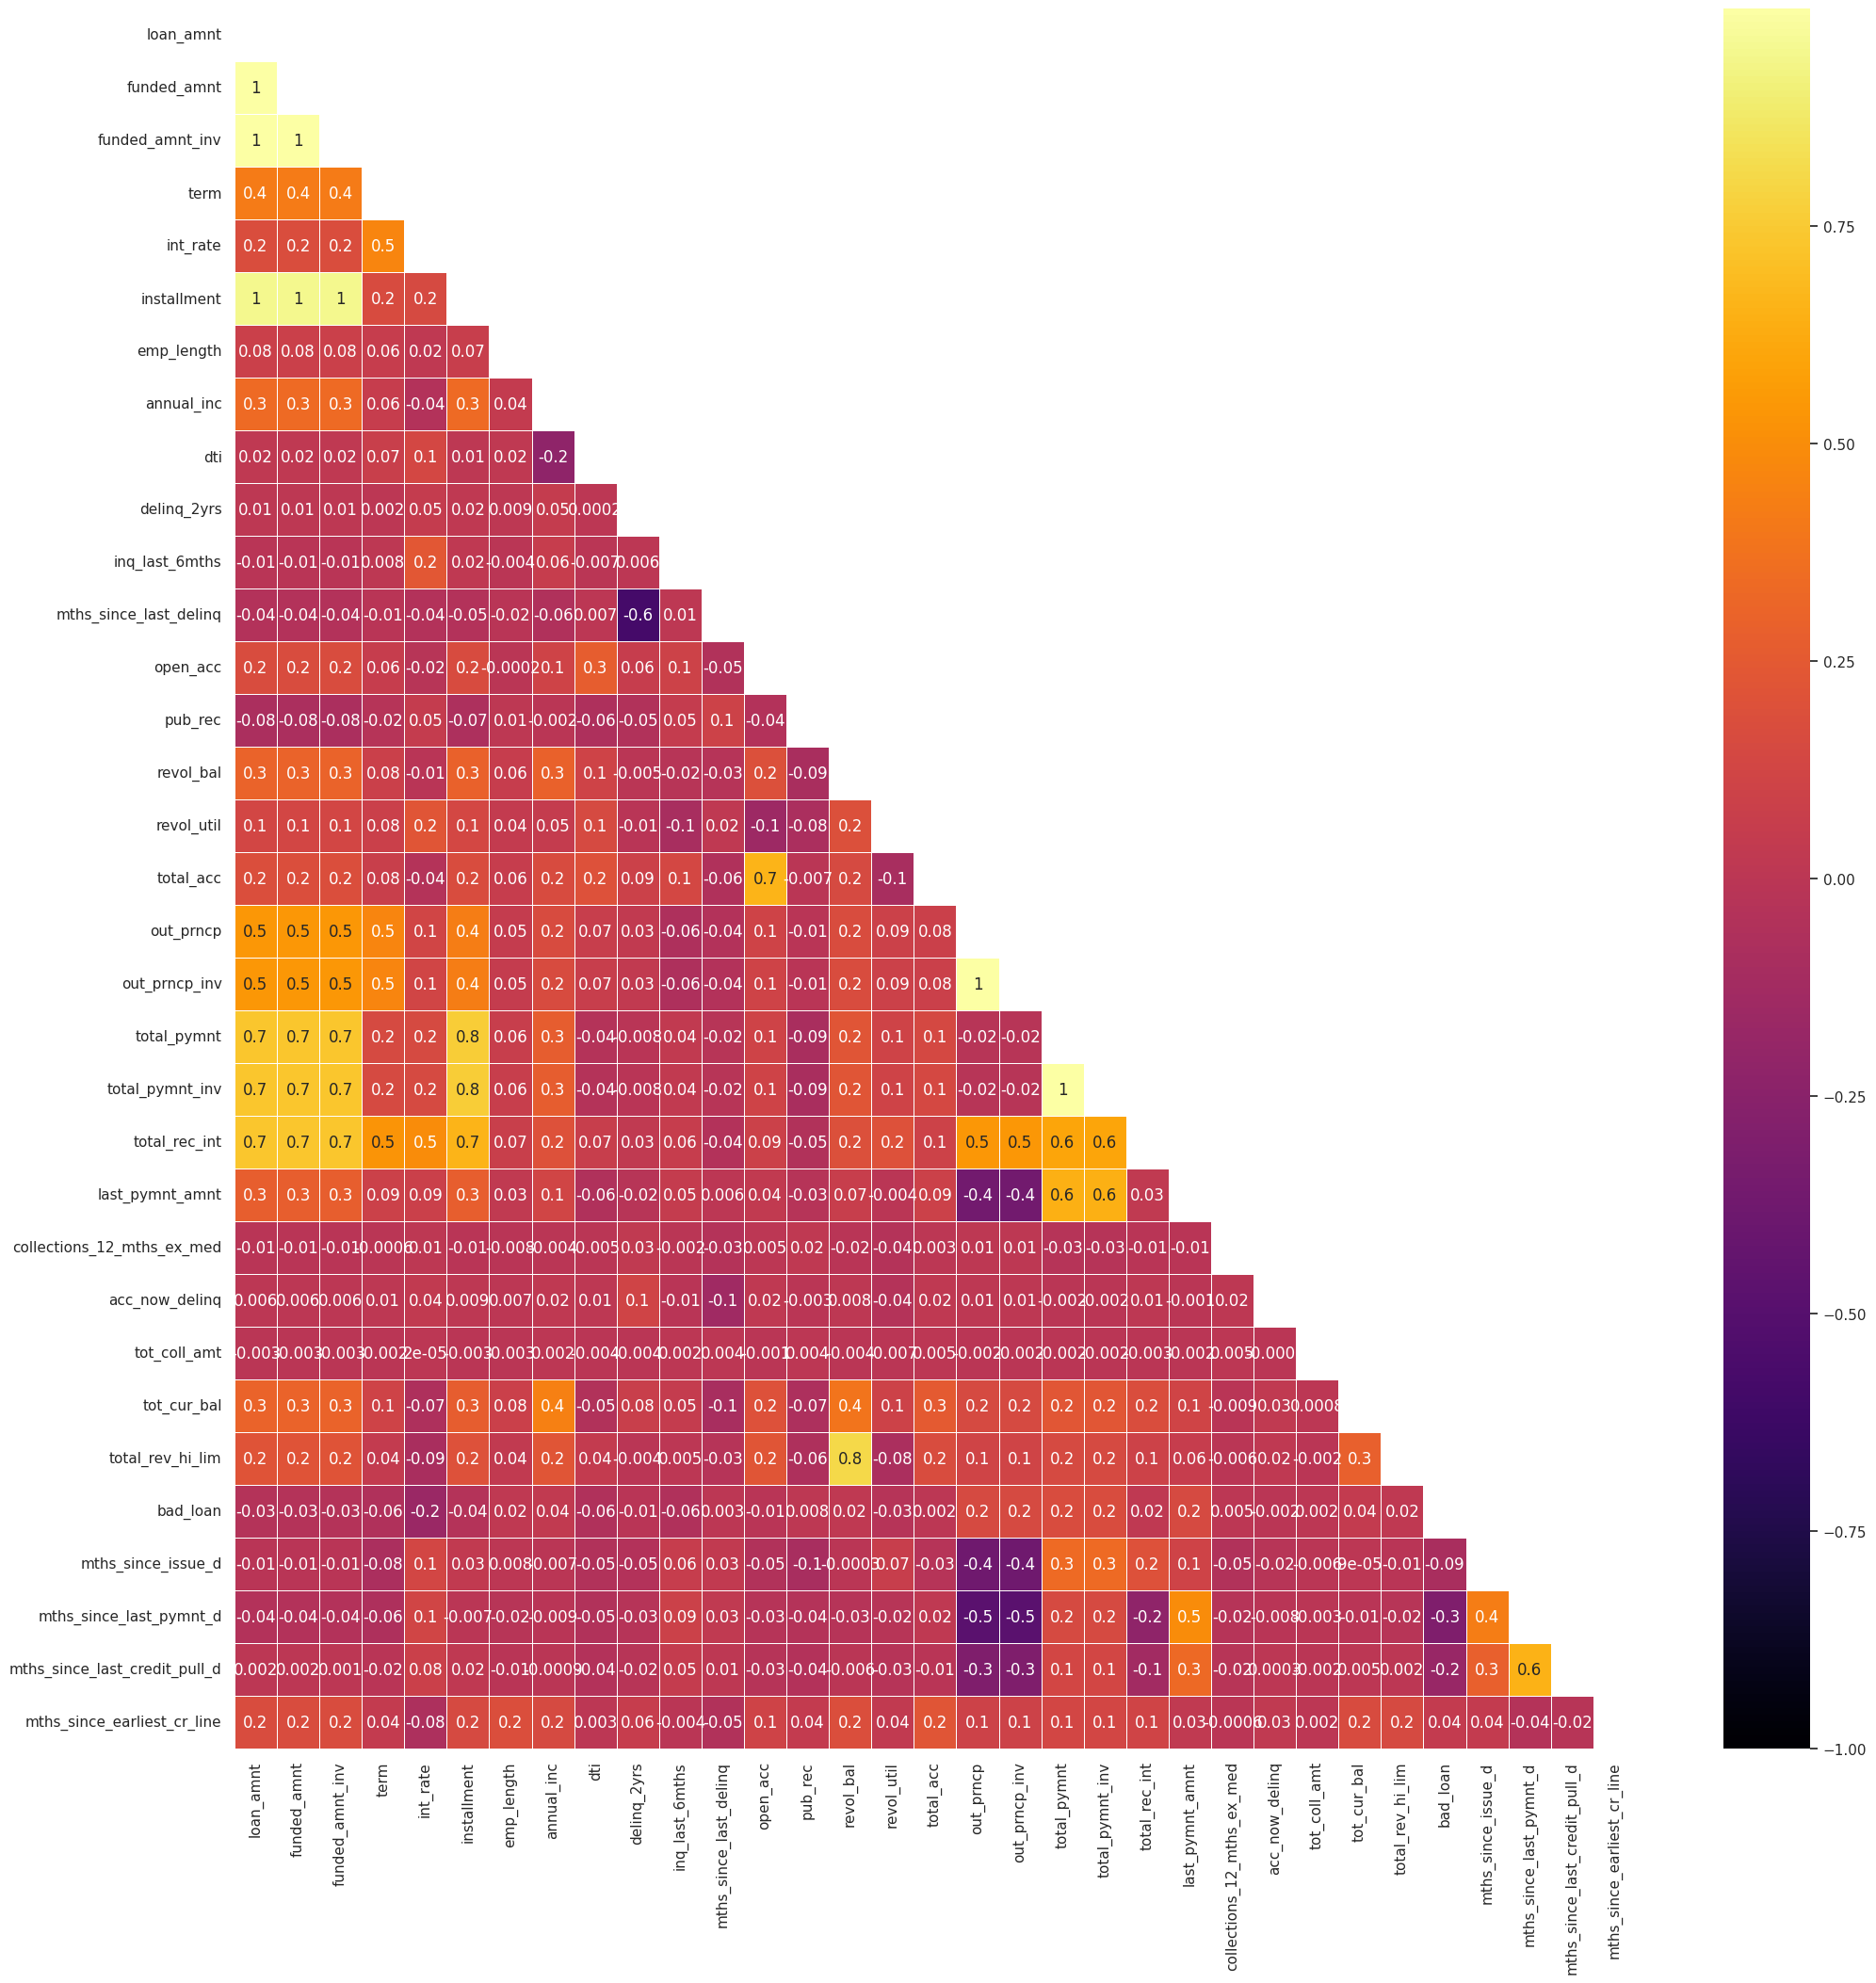

In [52]:
# correlation matrix with correlation co-effiecients
import numpy as np
mask = np.zeros_like(numeric_df.corr().fillna(0))
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(24,24))
sns.heatmap(numeric_df.corr(), mask=mask, annot=True,  cmap="inferno", vmin = -1, fmt='.1g', edgecolor='w', linewidth=0.6)

# Removing Multicollinear Features

In [53]:
 data.drop(columns=['loan_amnt', 'revol_bal', 'funded_amnt', 'funded_amnt_inv', 'installment',
                   'total_pymnt_inv',  'out_prncp_inv',  'total_acc'], inplace=True)

<Axes: >

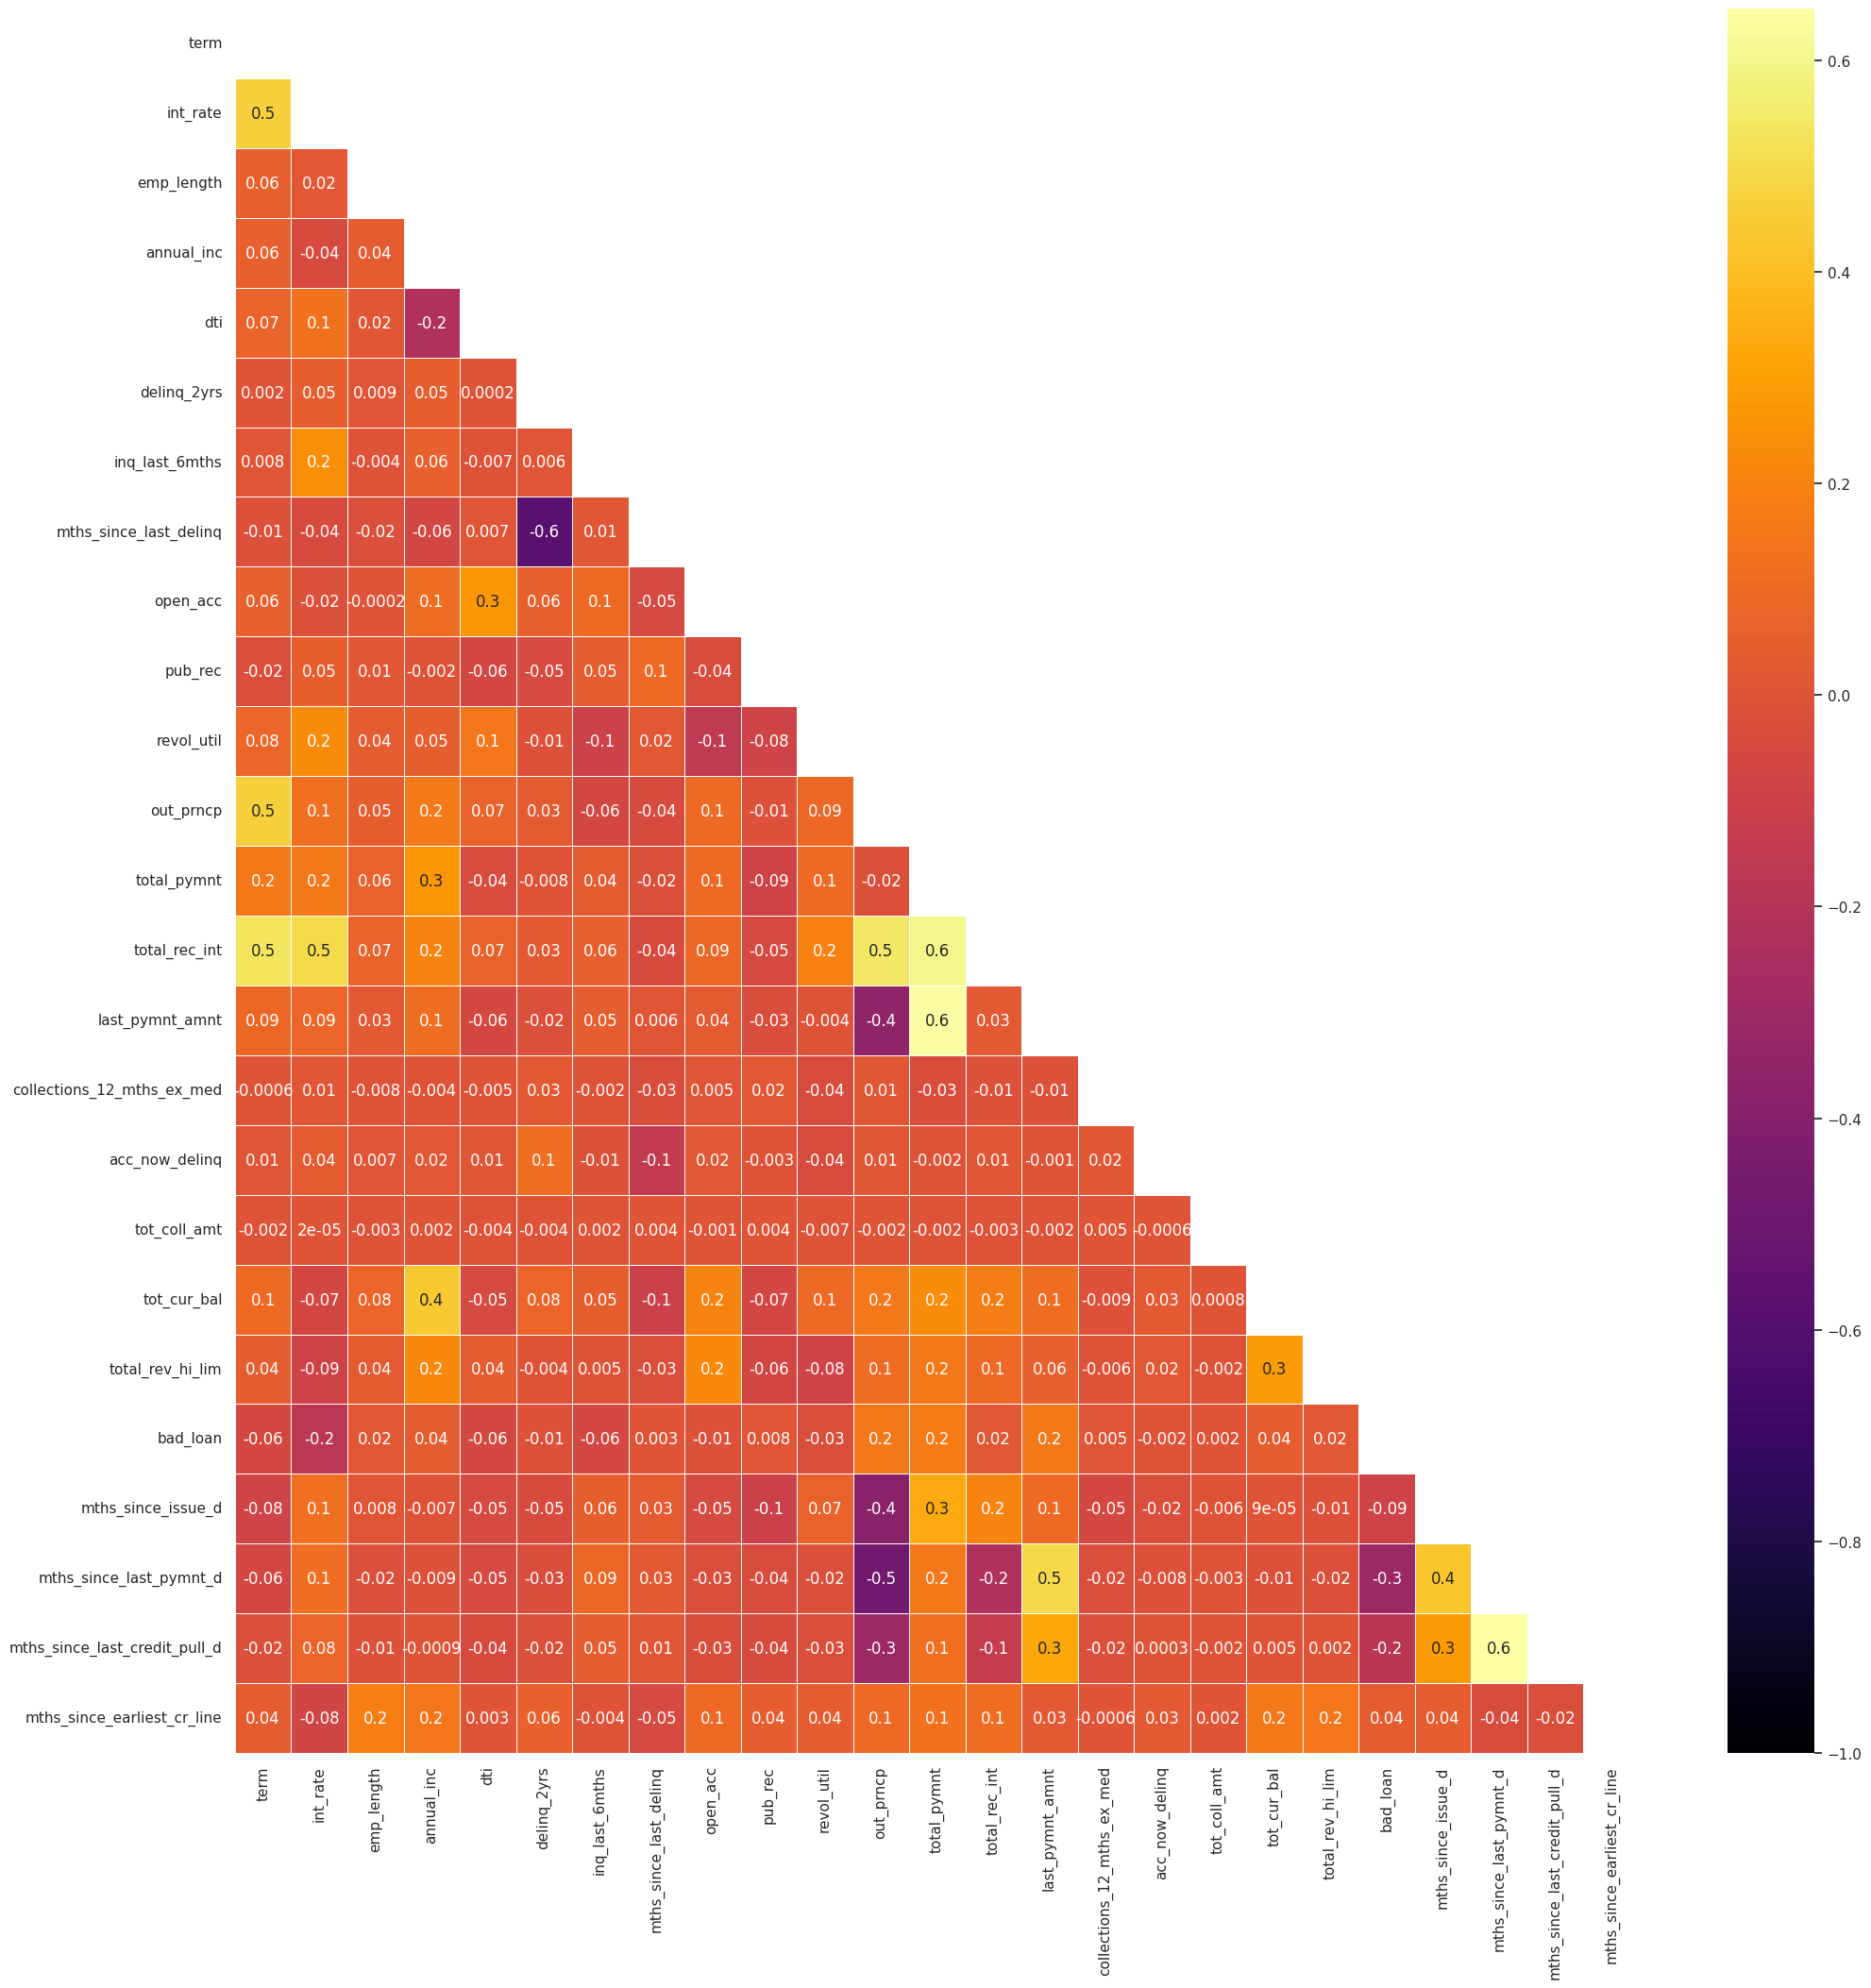

In [54]:
numeric_df = data.select_dtypes(include=[np.int64, np.float64])
mask = np.zeros_like(numeric_df.corr().fillna(0))
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(24,24))
sns.heatmap(numeric_df.corr(), mask=mask, annot=True,  cmap="inferno", vmin = -1, fmt='.1g', edgecolor='w', linewidth=0.6)

In [55]:
##descriptive statistics
data.describe()

,term,int_rate,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,...,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,bad_loan,mths_since_issue_d,mths_since_last_pymnt_d,mths_since_last_credit_pull_d,mths_since_earliest_cr_line
count,181686.000000,181686.000000,181686.000000,1.816860e+05,181686.000000,181686.000000,181686.000000,181686.000000,181686.000000,181686.000000,...,181686.000000,181686.000000,1.816860e+05,1.816860e+05,1.816860e+05,181686.000000,181686.000000,181686.000000,181686.000000,181686.000000
mean,42.896470,14.449868,6.324092,7.886698e+04,17.389873,0.638040,0.822942,33.724167,11.756382,0.189244,...,0.016418,0.009808,3.263843e+02,1.505644e+05,2.735155e+04,0.901897,76.719868,58.674631,55.902585,279.401798
std,10.860692,4.252272,3.607371,6.078531e+04,7.787230,1.104461,1.059299,21.716923,4.997763,0.557625,...,0.149082,0.107319,2.157745e+04,1.595617e+05,4.243696e+04,0.297455,6.946955,7.194128,4.903270,81.327565
min,36.000000,6.000000,0.000000,4.000000e+03,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,1.000000e+02,0.000000,67.000000,54.000000,54.000000,105.000000
25%,36.000000,11.670000,3.000000,5.000000e+04,11.530000,0.000000,0.000000,15.000000,8.000000,0.000000,...,0.000000,0.000000,0.000000e+00,3.245125e+04,1.230000e+04,1.000000,71.000000,54.000000,54.000000,223.000000
50%,36.000000,14.160000,7.000000,6.800000e+04,16.910000,0.000000,0.000000,30.000000,11.000000,0.000000,...,0.000000,0.000000,0.000000e+00,9.847150e+04,2.060000e+04,1.000000,76.000000,55.000000,54.000000,262.000000
75%,60.000000,17.140000,10.000000,9.402825e+04,22.900000,1.000000,1.000000,49.000000,14.000000,0.000000,...,0.000000,0.000000,0.000000e+00,2.255148e+05,3.400000e+04,1.000000,81.000000,61.000000,54.000000,320.000000
max,60.000000,26.060000,10.000000,7.500000e+06,39.990000,29.000000,7.000000,188.000000,84.000000,21.000000,...,20.000000,5.000000,9.152545e+06,8.000078e+06,9.999999e+06,1.000000,94.000000,93.000000,93.000000,608.000000


In [57]:
# Final 25 columns
data.columns

Index(['term', 'int_rate', 'grade', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'pymnt_plan', 'purpose',
       'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_util',
       'initial_list_status', 'out_prncp', 'total_pymnt', 'total_rec_int',
       'last_pymnt_amnt', 'collections_12_mths_ex_med', 'application_type',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'bad_loan', 'mths_since_issue_d', 'mths_since_last_pymnt_d',
       'mths_since_last_credit_pull_d', 'mths_since_earliest_cr_line'],
      dtype='object')

In [58]:
# data.to_csv('loan-data-25-feats.csv', index=False)

## Seprating categorical features from numerical

In [59]:
# seperating categorical features from numerical
categorical_features = data.select_dtypes(exclude='number')
numerical_features = data.select_dtypes(exclude='object')

In [60]:
# converting to dataframe
filled_data = data

In [61]:
preprocess_data = data

#checking for any missing values
missing = preprocess_data.isnull().sum()
missing[missing>0]

Series([], dtype: int64)

Finally no missing values

# Binning, Weight of Evidence (WoE), Information Value (IV)

- **Binning** create buckets of independent variables based on ranking  methods. Binning helps us converting continuous variables into categorical ones. This process allows us to understand feature performance better. The  insights from this part of the analysis can be useful in devising portfolio risk strategies. One simple binning example using "age" is given below for illustration.

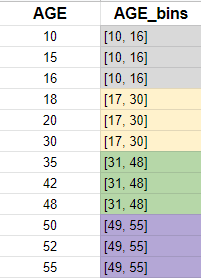

- **Weight of Evidence (WoE)** will help us to determine which categories should be binned together. WOE measures the strength of a bin in differentiating the Good and Bad accounts. WOE < 0 indicates that the variable bin is captures higher proportion of bad accounts.


- **Information Value (IV)** will help in determining which variables are useful for prediction in the logistic regression model. IV is the measure of overall predictive power of the variables and is very useful for feature selection.


**The formular of WoE and IV are as follows:**

$$\text{WoE} = [ln (\frac{\text{Relative frequency of Goods}}{\text{Relative frequency of Bads}})] \times 100$$

$$IV = \sum (\text{Distribution Good}_i - \text{Distribution Bad}_i) \times \text{WoE}_i$$

